In [1]:
import numpy as np

import adaptive_latents
from adaptive_latents import AnimationManager, Pipeline, CenteringTransformer, proSVD, Bubblewrap, VanillaOnlineRegressor, NumpyTimedDataSource, KernelSmoother, Concatenator, sjPCA
import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


## Intro video

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


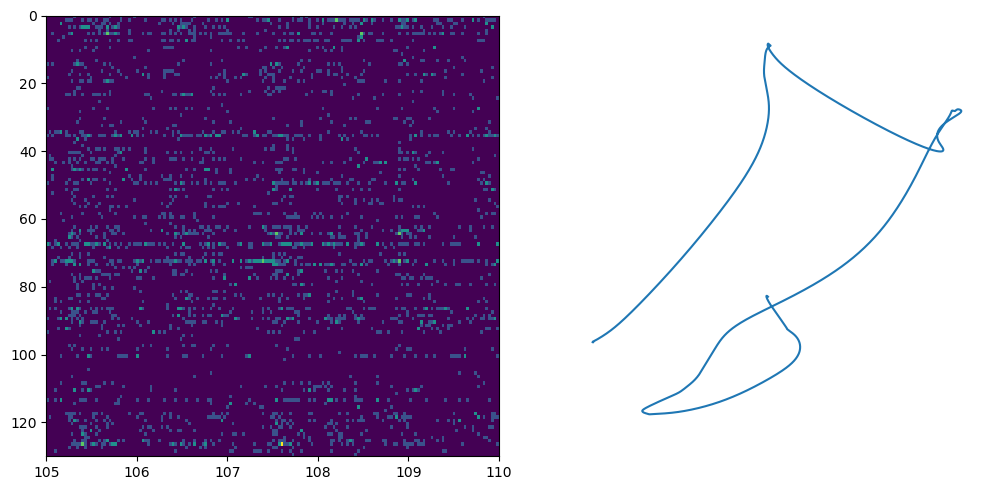

In [58]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()


## Combination and prediction video


In [19]:

d = datasets.Odoherty21Dataset()

streams = []
streams.append( (d.neural_data,     0) )
streams.append( (d.behavioral_data, 1) )
streams.append( (d.behavioral_data, 3) )

p1 = Pipeline([
    CenteringTransformer(input_streams={0:'X'}, output_streams={0:0}),
    KernelSmoother(tau=0.08/d.bin_width, input_streams={0:'X'}, output_streams={0:0}),
    Concatenator(input_streams={0: 0, 1: 1}, output_streams={0:2, 1:2, 'skip':-1}),
    pro:=proSVD(k=6, input_streams={2:'X'}, output_streams={2:2}),
    sjPCA(input_streams={2:'X'}, output_streams={2:2}),
])

p2 = Pipeline([
    bw:=Bubblewrap(
        num=100,
        eps=1e-3,
        step=1e-1,
        num_grad_q=3,
        sigma_orig_adjustment=5000,
        input_streams={2:'X'},
        output_streams={2:2},
    ),
    reg:=VanillaOnlineRegressor(
        input_streams={2:'X', 3:'Y'},
        output_streams={2:2},
    ),
])



video_dt = 0.05
video_ts = np.arange(200)*video_dt + 50 
streams.append( (NumpyTimedDataSource(np.nan * video_ts, video_ts), 'video') )


/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [ ]:
# vid = pf.PredictionVideo(d, fps=1/video_dt)

pbar = tqdm(total=video_ts[-1])
latents = []
latent_ts = []

latent_predictions = []
beh_predictions = []
prediction_ts = []

with AnimationManager(fps=1/video_dt) as am:
    for output, stream in Pipeline().streaming_run_on(streams, return_output_stream=True):
        # dim reduction part of pipeline
        output, stream = p1.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            latents.append(output)
            latent_ts.append(output.t)

        # prediction part of pipeline
        output, stream = p2.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            prediction_t = output.t+bw.dt*1
            alpha_pred = bw.get_alpha_at_t(prediction_t)
            latent_prediction = np.array(bw.mu[np.argmax(alpha_pred)])
            beh_prediction = reg.predict(alpha_pred)

            latent_predictions.append(latent_prediction)
            beh_predictions.append(beh_prediction)
            prediction_ts.append(prediction_t)
            
        
        if stream == 'video':
            ax: plt.Axes = am.axs[0,0]
            ax.cla()
            
            bw.scatter_data_with_decay(ax,np.squeeze(latents)[np.array(latent_ts) > 10])
            bw.show_bubbles_2d(ax)
            
            am.grab_frame()
            
            if output.t == video_ts[-1]:
                break

        pbar.update(output.t - pbar.n)


latents = np.squeeze(latents)
latent_predictions = np.squeeze(latent_predictions)
beh_predictions = np.squeeze(beh_predictions)
prediction_ts = np.squeeze(prediction_ts)



  0%|          | 0/59.95 [00:00<?, ?it/s]

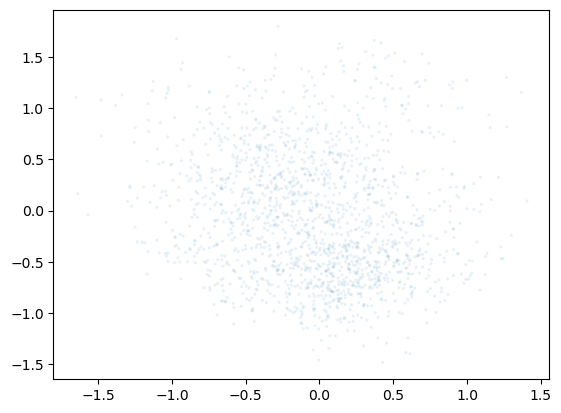

In [16]:

fig, ax = plt.subplots()
# ax.hist2d(latents[:,0], latents[:,1], bins=50);
s = np.array(latent_ts) > 10
ax.scatter(latents[s,0], latents[s,1], s=5, alpha=.1, c='C0', edgecolors='none')



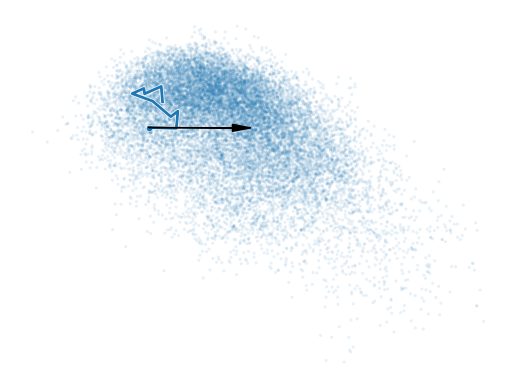

In [9]:

fig, ax = plt.subplots()

pf.plot_history_with_tail(ax, latents)
means = np.mean(latents, axis=0)
ax.arrow(latents[-1,0], latents[-1,1], means[0] - latents[-1,0], means[1] - latents[-1,1], zorder=5, head_width=.1, color='k')

ax.axis('off');



In [11]:
assert isinstance(d, datasets.Zong22Dataset)
desired_pattern = np.mean(latents[-101:-1], axis=0)
current_pattern = latents[-1]
desired_stim = desired_pattern - current_pattern

desired_pattern = (desired_stim @ pro.Q.T)[:d.neural_data.a.shape[-1]]

near_zero = np.abs(desired_stim) < 100
print(near_zero.sum())
desired_stim[near_zero] = np.nan


fig, ax = plt.subplots()
d.show_stim_pattern(ax, np.abs(desired_pattern))



AssertionError: 